## Objective

Spotify's editorial playlists are "carefully curated by [its] music experts and genre specialists from around the globe" (Spotify for Artists). Every artist knows the importance of being added to a Spotify editorial playlist. As an artist myself, I know when I get the notification that a song of mine has been added to a Spotify playlist that it will gain thousands of streams a day for the duration of its time on that playlist. One of my favorite playlists to be added to in the indie genre is 'undercurrents.' Wouldn't it be great as an artist if I could write and release songs that I knew would be best suited for this playlist? Knowing what type of song a playlist is looking for could help an artist choose which song to pitch. Further, I think it's important that artists know how their songs are categorized in terms of features. Are there certain aspects of a song that affect whether or not it is playlisted? My objective is to identify those aspects, as well as predict whether or not a song will be playlisted based on those aspects.

## Creating the Data

Using spotipy, I first pulled the tracks and artist names from 'undercurrents.' Then, I created a dataset of every artist's discography with an indicator variable = 1 if the song is on 'undercurrents' and 0 otherwise. Next, I wrote a function that added features of every track to the dataset. Finally, I scaled the features and dropped any songs that did not have features available. The resulting dataset has 1547 songs by 64 unique artists with 10 song features.

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import numpy as np

auth_manager = SpotifyClientCredentials()
sp = spotipy.Spotify(auth_manager=auth_manager)

# returns dataframe of all playlist tracks, track ids, artists, and artist ids given a playlist uri

def playlist_df(playlist):
    
    results = sp.playlist_tracks(playlist, fields = 'items')
    
    A = []
    B = []
    C = []
    D = []
      
    for i in range(len(results['items'])):
        A.append(results['items'][i]['track']['name'])
        B.append(results['items'][i]['track']['id'])
        C.append(results['items'][i]['track']['artists'][0]['name'])
        D.append(results['items'][i]['track']['artists'][0]['id'])
        
    dict = {'Track': A, 'Track ID': B, 'Artist': C, 'Artist ID': D}  
    
    df = pd.DataFrame(dict)
        
    return df

# returns lists of artist's discography in tracks and ids given artist id
    
def artist_albums(artist_id):
    
    track_ids = []
    albums = []
    tracks = []
    results = sp.artist_albums(artist_id, album_type='album')
    albums.extend(results['items'])
    
    
    while results['next']:
        results = sp.next(results)
        albums.extend(results['items'])
    
    unique = set()  # skip duplicate albums
    
    for album in albums:
        name = album['name'].lower()
        if name not in unique:
            unique.add(name)
            this_tracks, this_id = show_album_tracks(album)
            tracks += this_tracks
            track_ids += this_id
            
    this_tracks, this_id = top_tracks(artist_id)
    
    tracks += this_tracks
    track_ids += this_id
            
    tracks, ids = unique_tracks(tracks, track_ids)
    
    return tracks, ids

# given lists of tracks and ids, returns lists of only unique tracks and ids

def unique_tracks(ls_t, ls_i):
    unique_t = []
    unique_i = []
    for i in range(0,len(ls_t)):
        if ls_t[i] not in unique_t:
            unique_t.append(ls_t[i])
            unique_i.append(ls_i[i])
    return unique_t, unique_i

# given album, returns list of all tracks and track ids from that album

def show_album_tracks(album):
    ids = []
    tracks = []
    track_names = []
    results = sp.album_tracks(album['id'])
    tracks.extend(results['items'])
    
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
        
    for track in tracks:
        track_names.append(track['name'])
        ids.append(track['id'])
   
    return track_names, ids

# function that returns top tracks of artist

def top_tracks(artist_id):
    t = []
    d = []
    tracks = sp.artist_top_tracks(artist_id)
    for i in range(len(tracks['tracks'])):
        t.append(tracks['tracks'][i]['album']['name'])
        d.append(tracks['tracks'][i]['album']['id'])
    return t, d

# function that adds songs to df given current df's artist IDs

def add_songs(df):
    old_df = df 
    
    for i in range(0, len(df['Artist ID'])):
        
        artist = df['Artist'][i]
        artist_id = df['Artist ID'][i]
        
        tracks, ids = artist_albums(artist_id)
        
        for j in range(0, len(tracks)):
            new_df = pd.DataFrame([tracks[j], ids[j], artist, artist_id])
            new_df = new_df.transpose()
            new_df = new_df.rename(columns = {0: 'Track', 1: 'Track ID', 2: 'Artist', 3: 'Artist ID'}, index = {0: len(df['Artist ID'])+ i + 1})
            
            df = df.append(new_df)
        
    df2 = df.sort_values(by = ['Artist'])
    df2 = df2.reset_index(drop = True)


    df2['Playlisted'] = df2['Track'].isin(old_df['Track']).astype(int)
    
    return df2

def features(df):
    
    danceability = []
    energy = []
    key = []
    loudness = []
    mode = []
    speechiness = []
    acousticness = []
    instrumentalness = []
    liveness = []
    valence = []
    tempo = []
    dur = []
    sig = []
    ls = [danceability, energy, key, loudness, mode, speechiness,acousticness, instrumentalness, liveness, valence,
         tempo, dur, sig]
    quotes = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness','acousticness', 'instrumentalness', 'liveness', 'valence',
         'tempo', 'duration_ms', 'time_signature']
    
    for id_ in df['Track ID']:
        features = sp.audio_features(id_)
        if features == [None]:
            for item in ls:
                item.append(np.nan)
        else:
            features = features[0]
            for i,j in zip(ls,quotes):
                i.append(features[j])
                
    dic = {'Danceability': danceability, 'Energy': energy, 'Key': key, 'Loudness': loudness, 'Mode': mode,
            'Speechiness': speechiness, 'Acoustic': acousticness, 'Instrumental': instrumentalness,
           'Liveness': liveness, 'Valence': valence, 'Tempo': tempo, 'Dur': dur, 'Sig': sig}
    
    return dic

from sklearn.preprocessing import StandardScaler

def clean(df):
    df = df.dropna()
    df = df.reset_index(drop = True)
    addback = [df['Playlisted'], df['Artist ID'], df['Artist'], df['Track ID'], df['Track'],]
    to_scale = df.drop(columns = ['Playlisted','Track', 'Track ID', 'Artist','Artist ID'])
    scaler = StandardScaler()
    data_scaled = pd.DataFrame(scaler.fit_transform(to_scale), columns = to_scale.columns)
    
    for column in addback:
        data_scaled = pd.concat([pd.DataFrame(column), data_scaled], axis = 1)
 
    return data_scaled
    

In [2]:
def main():
    playlist_id = 'spotify:playlist:37i9dQZF1DX9myttyycIxA'
    df = playlist_df(playlist_id)
    df = add_songs(df)
    feats = pd.DataFrame(features(df))
    df = pd.concat([feats, df], axis = 1)
    df = clean(df)
    df.to_csv(r'/Users/harlanhutton/Documents/spotify/undercurrentsdata.csv', index = False)

In [3]:
main()

In [122]:
from IPython.display import display, HTML

data = pd.read_csv('/Users/harlanhutton/Documents/spotify/undercurrentsdata.csv')
data = data.drop(columns = ['Track', 'Track ID', 'Artist', 'Artist ID'])

def getDfSummary(dat):
        '''
        Get descriptive stats
        '''
        #Get the names of the columns
        cols = data.columns.values

        c_summ = []
        #Outer Loop for the cols
        for c in cols:
            #Count the NAs
            missing = sum(pd.isnull(dat[c]))
            #Use describe to get summary statistics, and also drop the 'count' row
            sumval = dat[c].describe().drop(['count'])
            #Now count distinct values...note that nunique removes missing values for you
            distinct = dat[c].nunique()
            #Append missing and distinct to sumval
            sumval = sumval.append(pd.Series([missing, distinct], index=['missing', 'distinct']))
            #Add each sumval to a list and then convert the entire thing to a DS
            c_summ.append(sumval)

        return pd.DataFrame(c_summ, index=cols)

desc = getDfSummary(data)
display(HTML(desc.to_html()))

,mean,std,min,25%,50%,75%,max,missing,distinct
Playlisted,8.144796e-02,0.273610,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,2.0
Danceability,2.826153e-16,1.000323,-3.473276,-0.683192,0.046309,0.737780,2.943571,0.0,537.0
Energy,-1.504578e-16,1.000323,-2.018635,-0.780452,-0.037885,0.777441,2.170557,0.0,728.0
Key,-3.272538e-17,1.000323,-1.503105,-0.937957,-0.090234,1.040063,1.605212,0.0,12.0
Loudness,1.482286e-16,1.000323,-5.506358,-0.559285,0.162708,0.719169,1.953029,0.0,1322.0
Mode,-5.755649e-17,1.000323,-1.856179,0.538741,0.538741,0.538741,0.538741,0.0,2.0
Speechiness,2.414932e-17,1.000323,-0.935206,-0.298731,-0.196895,-0.023985,17.755950,0.0,424.0
Acoustic,-4.951867e-17,1.000323,-1.357228,-1.025220,0.041470,1.037518,1.454304,0.0,876.0
Instrumental,-1.876686e-17,1.000323,-0.648457,-0.648133,-0.615268,0.396233,2.499837,0.0,1059.0
Liveness,-1.530952e-16,1.000323,-1.135876,-0.569656,-0.419191,0.222261,5.836948,0.0,517.0


Looking at the above description of the data, I can confirm that there are no missing values. and that all of the data minus the target variable is normalized with mean 0 and std 1. Looking at the number of distinct values, the variables range from binary (like mode), to almost all unique, like duration or tempo.

## Feature Covariance

As another means of exploratory analysis, I want to look at the covariance matrix of the features. There are a few correlations between features that make sense intuitively, like loudness and energy, acousticness and energy, valence and danceability, and valence and energy. Valence is the how positive (happy, cheerful) or negative (sad, angry) a song sounds. Thinking ahead to model selection, if I use a tree-based algorithm I will not need to correct for these correlations, as they are generally robust enough to handle these correlations. If I use a linear algorithm which is more sensitive to highly correlated features, I may want to drop some features or transform the data using Principal Components. However, because I don't have an overwhelming number of features, and most have correlations less than 0.3, I will probably not need to use PCA. 

In [98]:
Y = data['Playlisted']
X = data.drop('Playlisted',1)

corr = X.corr()
corr.style.background_gradient(cmap='coolwarm')

,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acoustic,Instrumental,Liveness,Valence,Tempo,Dur,Sig
Danceability,1.000000,-0.006881,0.026906,0.014847,-0.023697,0.035370,-0.012299,-0.142801,-0.068808,0.363463,-0.062979,-0.135371,0.026569
Energy,-0.006881,1.000000,0.014118,0.800639,-0.065761,0.054158,-0.706845,0.104648,0.198002,0.498156,0.221545,0.057916,0.122685
Key,0.026906,0.014118,1.000000,-0.003142,-0.185426,0.052507,0.016499,-0.008864,0.048300,0.025169,-0.005362,0.006786,0.059669
Loudness,0.014847,0.800639,-0.003142,1.000000,-0.044720,-0.049799,-0.635834,-0.043064,0.119346,0.353971,0.140552,0.021786,0.104532
Mode,-0.023697,-0.065761,-0.185426,-0.044720,1.000000,-0.058965,0.037589,-0.025139,-0.038768,-0.032536,0.062737,-0.003302,-0.015789
Speechiness,0.035370,0.054158,0.052507,-0.049799,-0.058965,1.000000,0.055620,0.008795,0.120495,0.036842,0.064810,-0.076996,-0.004747
Acoustic,-0.012299,-0.706845,0.016499,-0.635834,0.037589,0.055620,1.000000,0.072427,-0.119253,-0.363767,-0.146512,-0.045161,-0.105534
Instrumental,-0.142801,0.104648,-0.008864,-0.043064,-0.025139,0.008795,0.072427,1.000000,-0.012771,-0.047577,-0.011392,0.022426,-0.026725
Liveness,-0.068808,0.198002,0.048300,0.119346,-0.038768,0.120495,-0.119253,-0.012771,1.000000,0.097377,0.023513,-0.031715,-0.012217
Valence,0.363463,0.498156,0.025169,0.353971,-0.032536,0.036842,-0.363767,-0.047577,0.097377,1.000000,0.140570,-0.137486,0.083816


## Mutual Information

Next, I want to take a look at the mutual information between the features and target variable. I can get some clues as to the best drivers of playlisting, as well as use this if I decided to go for dimensionality reduction. In the graph below, I can see that key, mode, and signature do not have a strong relationship with playlisted. The rest of the mutual info between the features and playlisted make intuitive sense, except I was surprised to see that as loudness increases, the likelihood of being playlisted decreases.

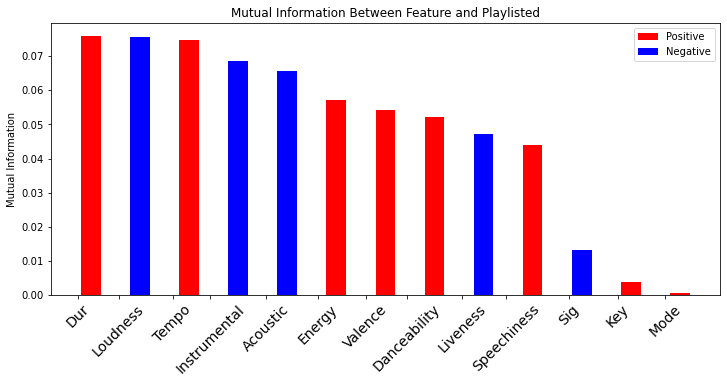

In [99]:
import sklearn.metrics as skm

def plotMI(dat, lab, width = 0.35, signed = 0):
    '''
    Draw a bar chart of the normalized MI between each X and Y
    '''
    X = dat.drop(lab, 1)
    Y = dat[[lab]].values
    cols = X.columns.values
    mis = []

    #Start by getting MI
    for c in cols:
        mis.append(skm.normalized_mutual_info_score(Y.ravel(), X[[c]].values.ravel()))

    #Get signs by correlation
    corrs = dat.corr()[lab]
    corrs[corrs.index != lab]
    df = pd.DataFrame(list(zip(mis, cols)), columns = ['MI', 'Lab'])
    df = pd.concat([df, pd.DataFrame(list(corrs), columns = ['corr'])], axis=1, ignore_index = False, join = "inner")

    if signed == 0:
        makeBar(df, 'MI', 'Lab', width)

    else:
        makeBarSigned(df, 'MI', 'Lab', width)


def makeBarSigned(df, h, lab,  width):
    '''
    Contains
    '''
    df_s = df.sort_values(by = [h], ascending = False)

    #Get a barplot
    ind = np.arange(df_s.shape[0])
    labs = df_s[[lab]].values.ravel()
    h_pos = (df_s[['corr']].values.ravel() > 0) * df_s.MI
    h_neg = (df_s[['corr']].values.ravel() < 0) * df_s.MI

    fig = plt.figure(facecolor = 'w', figsize = (12, 6))
    ax = plt.subplot(111)
    plt.subplots_adjust(bottom = 0.25)

    rec = ax.bar(ind + width, h_pos, width, color='r', label = 'Positive')
    rec = ax.bar(ind + width, h_neg, width, color='b', label = 'Negative')

    ax.set_xticks(ind + getTickAdj(labs, width))
    ax.set_xticklabels(labs, rotation = 45, size = 14)
    
    plt.legend()
    
def makeBar(df, h, lab,  width):
    '''
    Contains
    '''
    df_s = df.sort_values(by = [h], ascending = False)

    #Get a barplot
    ind = np.arange(df_s.shape[0])
    labs = df_s[[lab]].values.ravel() 

    fig = plt.figure(facecolor = 'w', figsize = (12, 6))
    ax = plt.subplot(111)
    plt.subplots_adjust(bottom = 0.25)

    rec = ax.bar(ind + width, df_s[h].values, width, color='r')

    ax.set_xticks(ind + getTickAdj(labs, width))
    ax.set_xticklabels(labs, rotation = 45, size = 14)


def getTickAdj(labs, width):
    lens = list(map(len, labs))
    lens = -1 * width * (lens - np.mean(lens)) / np.max(lens)
    return lens
    
plotMI(data, 'Playlisted', 0.4, signed=1)
plt.title('Mutual Information Between Feature and Playlisted');
plt.ylabel('Mutual Information');

## Variable Importance

A final exploratory step I want to take is variable importance. This is just one more way I can see which features will add the most significance to a potential model. Because signature and mode are again the least important, I'm going to drop them from the dataset with confidence that it will not affect a future model's accuracy. Because loudness did better than energy in terms of both mutual info and variable importance, I'm going to drop energy as well to avoid that correlation of 0.8.

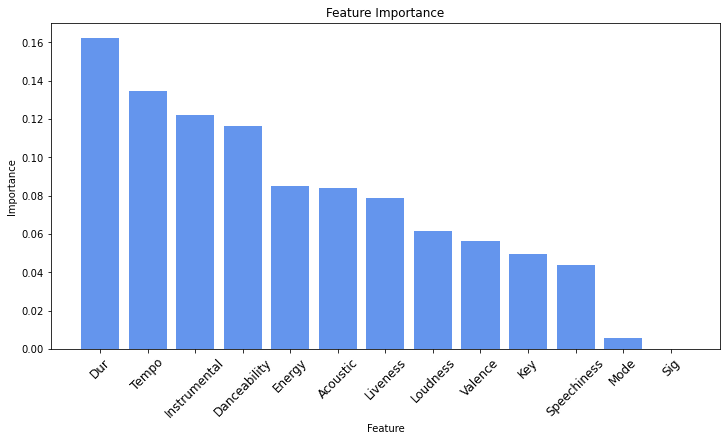

In [100]:
# add features and their importances to a dictionary

from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

dt = DecisionTreeClassifier()
dt.fit(X,Y)
feature_mi = dt.feature_importances_
mi_dict = dict(zip(X.columns.values, feature_mi))

# sort dict and plot 

sorted_dict = {k: v for k, v in sorted(mi_dict.items(), reverse = True, key=lambda item: item[1])}

plt.figure(facecolor = 'w', figsize = (12, 6))
plt.bar(sorted_dict.keys(), sorted_dict.values(), color = 'cornflowerblue')
plt.xticks(range(X.shape[1]), sorted_dict.keys(), fontsize=12, rotation=45)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

## Welcome to the Model Bakeoff!

Now that I feel I have a good grasp on my features, I am going to run a bakeoff for different models. Because my data is imbalanced, I am going to upsample as well. (I will first run the bakeoff on the data without upsampling, and then compare performance of models). To confirm my features analysis, I will also assess the performance of the models with the dropped features and without.

### Design Parameters:

**Algorithms:** Logistic Regression, Naive Bayes, Random Forest, Decision Tree, K Nearest Neighbors, Gradient Boosted Tree

**Hyperparameters:** Need to choose appropriate ranges for every model's specific hyperparams.

**Features**: All included vs. without energy, signature, and mode

**Imbalanced Data:** Without upsampling playlisted songs vs. with upsampling playlisted songs

### Evaluation:
I will use AUC, accuracy, precision, and recall to evaluate the models. I will split the data into 80% train, 20% test.

In [104]:
from sklearn.model_selection import *
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *

models = [LogisticRegression(), GaussianNB(), RandomForestClassifier(), DecisionTreeClassifier(), KNeighborsClassifier(), GradientBoostingClassifier()]

def plot_roc_curve(models, data, dropped, upsampled):
    
    fpr = []
    tpr = []
    auc = []
    acc = []
    recall = []
    precision = []
    
    if dropped == True:
        data = data.drop(['Sig', 'Mode', 'Energy'],1)
    
    X_train, X_test, y_train, y_test = train_test_split(data.drop('Playlisted',1), data['Playlisted'], test_size=0.2, random_state=42)
    data_train, data_test = pd.concat([X_train, y_train], axis = 1), pd.concat([X_test,y_test], axis = 1)
    
    if upsampled == True:
        
        sm = SMOTE(random_state=12, sampling_strategy = 1.0)
        X_train, y_train = sm.fit_sample(X_train, y_train)
    
    plt.figure(figsize=(20,10))
    
    for model in models:
        
        mod = model.fit(X_train, y_train)
            
        preds = mod.predict_proba(X_test)[:,1]
        this_fpr,this_tpr,thresh = roc_curve(y_test, preds)
        auc.append( roc_auc_score(y_test, preds) )
        fpr.append( this_fpr )
        tpr.append( this_tpr )
        acc.append(accuracy_score(y_test, mod.predict(X_test)))
        recall.append(recall_score(y_test,mod.predict(X_test) ))
        precision.append(precision_score(y_test, mod.predict(X_test), zero_division = 0))
        
        plt.plot(this_fpr,this_tpr, label = mod)
        
    plt.plot([0,1],[0,1], 'b--', label = 'Random Chance')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend();
    
    df = pd.DataFrame(models, columns = ['Model'])
    df['Accuracy'],df['AUC'],df['Recall'],df['Precision'] = acc,auc,recall,precision
    
    return df
    

,Model,Accuracy,AUC,Recall,Precision
0,LogisticRegression(),0.603226,0.605119,0.566667,0.133858
1,GaussianNB(),0.464516,0.647976,0.733333,0.122222
2,"(DecisionTreeClassifier(max_features='auto', r...",0.945161,0.846964,0.600000,0.782609
3,DecisionTreeClassifier(),0.854839,0.770833,0.666667,0.363636
4,KNeighborsClassifier(),0.754839,0.863631,0.833333,0.260417
5,([DecisionTreeRegressor(criterion='friedman_ms...,0.880645,0.812262,0.500000,0.405405


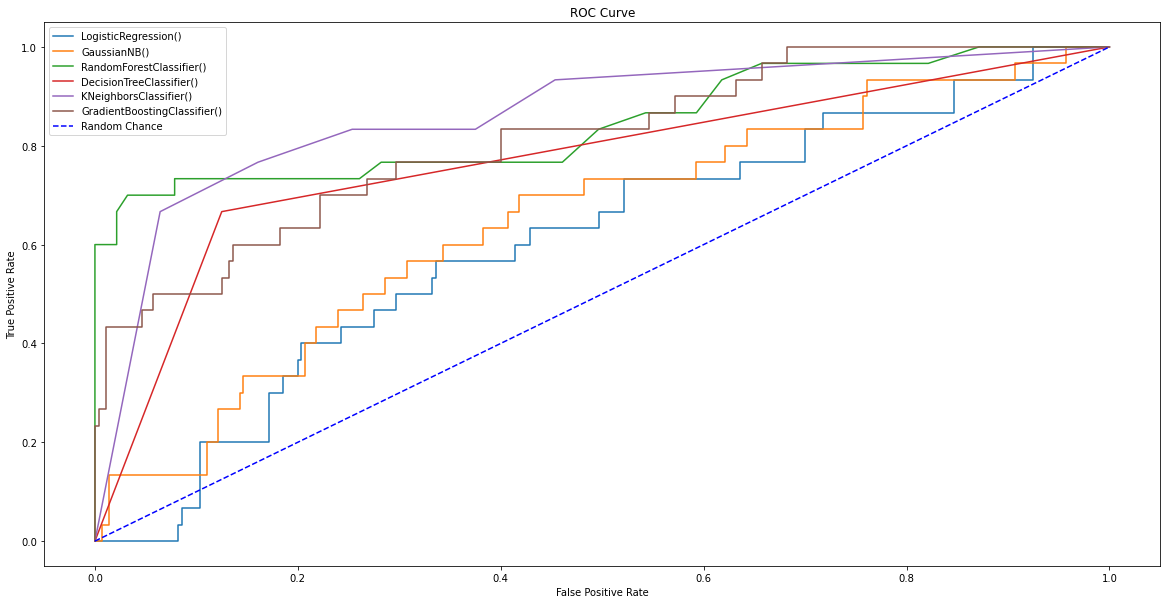

In [109]:
plot_roc_curve(models, data, dropped = True, upsampled = True)

### Upsampling

,Model,Accuracy,AUC,Recall,Precision
0,LogisticRegression(),0.632258,0.613810,0.566667,0.144068
1,GaussianNB(),0.500000,0.679881,0.800000,0.138728
2,"(DecisionTreeClassifier(max_features='auto', r...",0.954839,0.849940,0.666667,0.833333
3,DecisionTreeClassifier(),0.880645,0.740476,0.566667,0.414634
4,KNeighborsClassifier(),0.793548,0.904702,0.900000,0.306818
5,([DecisionTreeRegressor(criterion='friedman_ms...,0.874194,0.830238,0.533333,0.390244


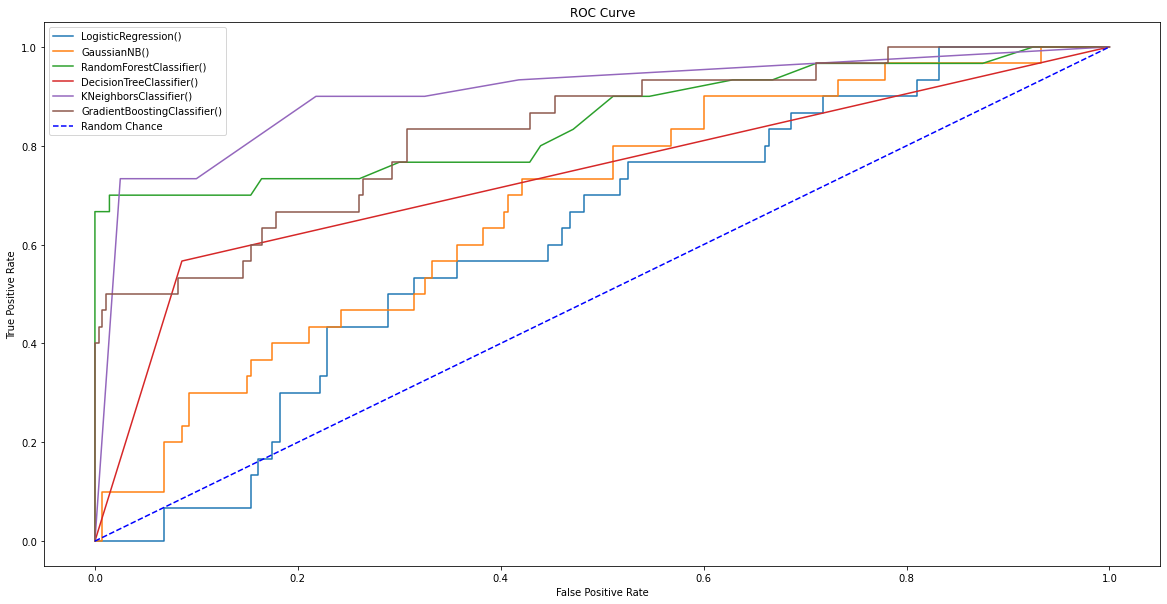

In [111]:
plot_roc_curve(models, data, dropped = False, upsampled = True)

In [114]:
from IPython.core.display import display, HTML
display(HTML(data))

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().